# Working with Time Series Data

## Learning objectives

In this tutorial, we will:
- count and filter data containing time-series points
- apply functions to time-series data and filter both individual points and entire rows based on the results

You should already have an understanding of:
- `nested-pandas` (see https://nested-pandas.readthedocs.io/en/latest/)

## Introduction

Each object in a row has columns that describe the properties of that object.  In the case of catalogs with time series data, some columns are lists, having many points per object, each with their own properties, and one of those properties is time.  Thus each object has data describing measurements over time.

Moreover, each row may have a different number of data points in its time series, meaning that it can be a ragged data set.  One common use case of this capability, which we will explore in this tutorial, is to store and process an object's light curve.

This structure creates some challenges, because at times you need to filter and operate on the rows as a whole, and sometimes you need to filter and operate on the points that make up the light curves.  These operations can further change the number of points within each light curve.  `lsdb` and `nested_pandas` make this workflow possible in a compact and efficient way.

## Open a catalog

In [1]:
import lsdb

In [2]:
from dask.distributed import Client

# Will be used implicitly for all distributed operations
client = Client(n_workers=4, memory_limit="auto")

The ZTF DR 22 catalog contains light curve data, with multiple time points for each object.
It's good practice to work with a small part of the catalog first, by using a cone search, say, before running computations across all of its partitions.

Note that the lightcurve data appears as list types in the schema.

In [3]:
ztf_objects = lsdb.open_catalog(
    "https://data.lsdb.io/hats/ztf_dr22",
    search_filter=lsdb.ConeSearch(ra=254.5, dec=35.3, radius_arcsec=1800),
)
ztf_objects

,objectid,filterid,objra,objdec,nepochs,hmjd,mag,magerr,clrcoeff,catflags
npartitions=1,,,,,,,,,,
"Order: 5, Pixel: 2378",int64[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow],list<element: int32>[pyarrow]


## 1. The time series light curve data

These list types, the columns which describe the light curve data, are (from https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/dr22/ztf_release_notes_dr22.pdf):

  - `hmjd` (Heliocentric-based Modified Julian Date)
  - `mag` (Calibrated magnitude for a source)
  - `magerr` (Corresponding 1-σ uncertainty in mag estimate)
  - `clrcoeff` (Linear color coefficient term from photometric calibration)
  - `catflags` (Photometric/image quality flags encoded as bits)

Regarding `catflags`, Note 9b in the above document states: "If you demand perfectly clean extractions at every epoch, we advise specifying catflags = 0 when querying lightcurve epochs."  We will do that in this tutorial.

What this means is that the `nepochs` column, which specifies how many points there are in the list columns, will not be a reliable count following filtering.  We will address this following filtering.

## 1.1 Nesting the light curve data

Rather than continue to deal with the list columns as individual lists, it is much more tractable to create a nested column out of them, so that all of the lightcurve data is grouped together, visually and computationally.  The `.nest_lists` method does this.

Afterward, we'll peek at the top three rows using `.head()`.

In [4]:
%%time
ztf_objects = ztf_objects.nest_lists(
    list_columns=["hmjd", "mag", "magerr", "clrcoeff", "catflags"],
    name="lc",  # name to give the resulting nested column
)
ztf_objects.head(3)

CPU times: user 4.62 s, sys: 1.65 s, total: 6.26 s
Wall time: 1min 30s


objectid  filterid       objra     objdec  \
_healpix_29                                                             
669362595299170956  1722203100001567         2  254.563019  34.803379   
669362595506888097   681212200003914         2  254.564301  34.804192   
669362595508866719  1722203100001554         2   254.56424  34.804264   

                    nepochs                                                 lc  
_healpix_29                                                                     
669362595299170956        1  [{hmjd: 58294.3155, mag: 21.090492, magerr: 0....  
669362595506888097       32  [{hmjd: 58198.49622, mag: 21.547998, magerr: 0...  
669362595508866719        6  [{hmjd: 58292.29516, mag: 21.082235, magerr: 0...

Note that in the preview above, the number of light curve points for each object is different.

Note further that throughout *most* of this notebook, the operations we request are delayed.  They aren't computed until `.compute()` is called, or until a preview function, like `.head()`.

## 1.2 Querying (filtering) the time series data in the nested column

Now the nested column `lc` contains all of the time series data.  We want to only keep the perfectly clear observations, those with `lc.catflags == 0`.  The `.query()` method, when used on nested columns, goes *inside* the nest, keeping only those nested rows which satisfy the condition.

We'd also like to focus on the r-band only, which is `filterid == 2`.  This column is *not* nested, but applies to every point in the lightcurve.  This also means that we can't query it *in the same expression* as the catflags, that is, we cannot write `.query("filterid == 2 and lc.catflags == 0")`, because that kind of cross-nest filtering isn't supported yet.

But we can accomplish the identical effect by simply chaining the two queries.

In [5]:
filtered_catalog = ztf_objects.query("filterid == 2")
filtered_catalog = filtered_catalog.query("lc.catflags == 0")

This filtering may have completely removed all of the points from some objects' light curves.  Drop rows for which this is true.

In [ ]:
# Using map_partitions to drop rows with NaN in lc.mag
filtered_catalog = filtered_catalog.map_partitions(lambda df: df.dropna(subset=["lc.mag"]))

## 2. Analysis of time series data

Let's compute the period of each time series with a Lomb-Scargle periodogram.  As a prerequisite, we want to use as input only brighter points, those where the median magnitude is brighter than 16.

We want to compute a new column named `median_mag` which contains the median magnitude, which is *not* nested (it will apply to the entire 
row), and we want to add this column to our catalog.  We will use the `.map_rows` function, which is so named because it allows us to map a function onto each row of the catalog, pulling in all column values and nested information.

Some things to note about the code here:
  - We use `append_columns=True`, because we want the new columns to be appended to our existing columns (rather than creating a new single-column catalog).
  - For every input column provided, the user-defined function must have a parameter which will receive that column.  We only provide one here, called `"lc.mag"`, and so `median_mag` only takes a single argument.
  -  We are obliged to provide `meta=`, which is a description of the type of our new column(s), and includes each column's name and type.  This is a requirement when using `.map_rows()`.

In [ ]:
import numpy as np


def median_mag(row):
    return np.median(row["lc.mag"])
    # return {"median_mag": np.median(row["lc.mag"])}


catalog_w_features = filtered_catalog.map_rows(
    median_mag,  # our user-defined function
    columns=["lc.mag"],  # names of the column(s) to pass to the function
    output_names=["median_mag"],  # name(s) of the new column(s)
    meta={"median_mag": float},  # for Dask: describe the type of the output
    append_columns=True,
)
catalog_w_features

,objectid,filterid,objra,objdec,nepochs,lc,median_mag
npartitions=1,,,,,,,
"Order: 5, Pixel: 2378",int64[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [...",float64


Note that the resulting `catalog_w_features` has our new columns, `median_mag`, at the right.  We can now use this to filter rows (including the time series nested with each row under `lc`) using `.query()`:

In [8]:
catalog_w_features = catalog_w_features.query("median_mag < 16")

We'd also like to ignore time series data that has fewer than 10 detections.

We can't use `nepochs` for anymore, since it included observations for which `catflags != 0`.  What we'll do instead is use a function from `nested_pandas` called `count_nested`, which is able to count all of the points per nested field.  This function adds a column to its input, named `n_{column}`, or `n_lc` in this case, since we're counting the length of the sub-columns within `lc`.

We'll apply this function using `.map_partitions`, which, like `.map_rows`, applies a function in parallel across the partitions of the catalog, but with a slightly different syntax.

Note that we don't need to supply `meta=` to `.map_partitions`.  This is because `count_nested` correctly handles the case of an
empty input, producing an empty output with the right structure.

Now that the catalog has the new column `n_lc`, we can filter out any time series data having fewer than 10 detections.

In [9]:
from nested_pandas.utils import count_nested


def count_points(pts):
    # Asked to count `lc`, this will add a column called `n_lc`
    return count_nested(pts, "lc")


catalog_w_features = catalog_w_features.map_partitions(count_points)
catalog_w_features = catalog_w_features.query("n_lc >= 10")

### 2.1 Applying the periodogram to the qualifying time series data

Now we've got good data for computing a periodogram!  The data now has these properties:
  - perfectly clean extractions (`lc.catflags == 0`)
  - r-band only (`filterid == 2`)
  - median of `lc.mag` is brighter than 16
  - at least 10 points

Once again, we'll use `Catalog.map_rows` to map a function onto each row (each timeseries) and produce two new columns for our catalog:
  - `period` (the period of the peridogram)
  - `false_alarm_prob` (the probability that the periodogram peak arose from noise rather than a true signal, and is hence a false alarm)

Since Lomb-Scargle requires time, magnitude, and magnitude error, we need to pass these three inputs to it.

In [10]:
from astropy.timeseries import LombScargle


def extract_period(row):
    time = row["lc.hmjd"]
    mag = row["lc.mag"]
    error = row["lc.magerr"]
    ls = LombScargle(time, mag, error)
    freq, power = ls.autopower()
    argmax = np.argmax(power)
    period = 1.0 / freq[argmax]
    false_alarm_prob = ls.false_alarm_probability(power[argmax])
    return {"period": period, "false_alarm_prob": false_alarm_prob}


catalog_w_features = catalog_w_features.map_rows(
    extract_period,
    # Column names specifying function arguments
    columns=["lc.hmjd", "lc.mag", "lc.magerr"],
    # Returned data type shape
    meta={"period": float, "false_alarm_prob": float},
    append_columns=True,
)
catalog_w_features

,objectid,filterid,objra,objdec,nepochs,lc,median_mag,n_lc,period,false_alarm_prob
npartitions=1,,,,,,,,,,
"Order: 5, Pixel: 2378",int64[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [...",float64,int32,float64,float64


Now we have everything we need to be able to select light curves by their period.  Let's focus on those without a false alarm which are close to having a period between 1.5 and 9.5.

Note that because both of these columns are at the same nesting level (the base) we can run the query with logical operators like `and`.

In [11]:
periodic_catalog = catalog_w_features.query("false_alarm_prob < 1e-10 and 1.5 < period < 9.5")

### 2.2 Computing and plotting

Operations have run suspiciously quickly so far because no computation has been done yet, only some validation of structure while Dask builds the task graph invisibly.  We can now realize the computation by calling `.compute()`.

In [12]:
%%time
periodic_df = periodic_catalog.compute()
periodic_df

/Users/dbranton/.virtualenvs/lsdb/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dbranton/.virtualenvs/lsdb/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


CPU times: user 4.98 s, sys: 1.67 s, total: 6.64 s
Wall time: 1min 42s


objectid  filterid       objra     objdec  nepochs  \
_healpix_29                                                                     
669389465489798434  680209200002339         2  254.245834  34.911369     1495   
669411015865751384  680213300009232         2   254.45752   35.34235     1403   
669558955615458377  681216300004749         2  254.589752  35.765709     1545   

                                                                   lc  \
_healpix_29                                                             
669389465489798434  [{hmjd: 58198.39514, mag: 15.919156, magerr: 0...   
669411015865751384  [{hmjd: 58198.39511, mag: 14.103342, magerr: 0...   
669558955615458377  [{hmjd: 58198.42248, mag: 15.41374, magerr: 0....   

                    median_mag  n_lc    period  false_alarm_prob  
_healpix_29                                                       
669389465489798434   15.911603  1397  5.714512      1.125756e-43  
669411015865751384   13.564873  1313  1.700147      0.000000e+00  
669558955615458377   15.388121  1452  8.966459      1.788198e-29

Only a few!  The one with 1313 points is HZ Her, a bright X-ray binary system. Let's plot it.

Text(0.5, 1.0, 'Object ID: 680213300009232, period: 1.700 d')

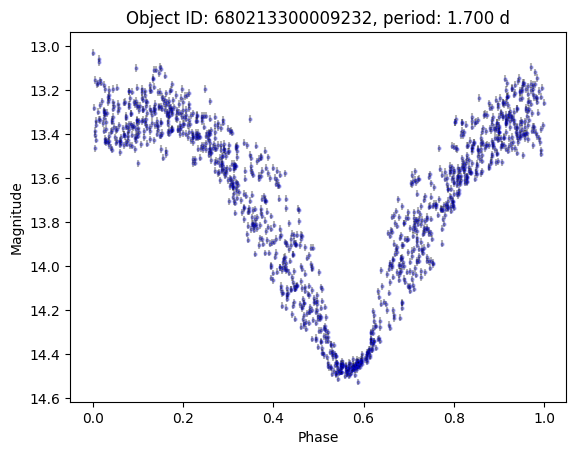

In [13]:
import matplotlib.pyplot as plt

row = periodic_df.iloc[1]
lc = row.lc

peak_mjd = lc["hmjd"][lc["mag"].idxmin()]
lc["phase"] = (lc["hmjd"] - peak_mjd) % row.period / row.period

plt.errorbar(
    lc["phase"],
    lc["mag"],
    lc["magerr"],
    alpha=0.3,
    ls="none",
    marker="o",
    markersize=2,
    markeredgecolor="blue",
    color="black",
)
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.title(f"Object ID: {row.objectid}, period: {row.period:.3f} d")

## Close the Dask client

In [14]:
client.close()

## About

**Author(s):** Konstantin Malanchev, Derek Jones

**Last updated on:** Oct 27, 2025

If you use lsdb for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).